<a href="https://colab.research.google.com/github/alaguilarunal/Ising_model/blob/main/Tarea_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
import time
from random import randint,choice,sample,uniform,random
from collections.abc import Callable
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import ipywidgets as widgets
from IPython.display import display,clear_output

import time

#Problema 1

Considerar el modelo de Ising

##Implementación de clases para la generación de los grafos

Para la actualización del spin de cada nodo, la función de actualización definido en el libro de Ollen:

\begin{equation}
\begin{aligned}
X_{n+1}(x) = \begin{cases}
+1 & \text{si } U_{n+1} < \frac{\exp(2\beta (k_+(x, \xi) - k_-(x, \xi)))}{\exp(2\beta (k_+(x, \xi) - k_-(x, \xi))) + 1} \\
-1 & \text{de lo contrario}.
\end{cases}
\end{aligned}
\end{equation}

Donde:



*   La ecuación para actualizar el spin es  $X_{n+1}(x)$ y depende de $U_{n+1}$.
*   $U_{n+1}$ es un número aleatorio uniformemente distribuido entre 0 y 1.
*   $k_+(x, X_n)$ es el número de vecinos del nodo $x$ que tienen spin $+1$ en la configuración actual $X_n$
*   $k_-(x, X_n)$ es el número de vecinos del nodo $x$ que tienen spin $-1$ en la configuración actual $X_n$.
*   Elemento de lista $\beta = \frac{1}{k_B T}$ es el inverso de la temperatura, donde $k_B$ es la constante de Boltzmann y $T$ es la temperatura.

In [ ]:

class ColourNode:
    __slots__ = ('colour', 'neighbors', 'neighbors_colour_count')

    def __init__(self, colour_count: int) -> None:
        # Asigna un color aleatorio al nodo entre -1 y colour_count-1
        self.colour = choice([-1, 1])
        # Inicializa la lista de vecinos
        self.neighbors = []
        # Inicializa el conteo de colores de los vecinos con ceros
        self.neighbors_colour_count = [0] * colour_count

    # Método para interconectar este nodo con otro nodo
    def inteconnect_neighbor(self, neighbor: 'ColourNode') -> None:
        # Añade el nodo vecino a la lista de vecinos
        self.neighbors.append(neighbor)
        # Añade este nodo a la lista de vecinos del nodo vecino
        neighbor.neighbors.append(self)
        #print(f"Append: ",self)
        #print(f"neighbor: ",neighbor)
        # Actualiza el conteo de colores de los vecinos para ambos nodos
        self.__add_colour_count(neighbor.colour)
        neighbor.__add_colour_count(self.colour)

    # Método privado para incrementar el conteo de un color específico entre los vecinos
    def __add_colour_count(self, colour: int) -> None:
        self.neighbors_colour_count[colour] += 1
        #print(f"Conteo de vecinos: ",self.neighbors_colour_count[colour])

    # Método privado para decrementar el conteo de un color específico entre los vecinos
    def __subtract_colour_count(self, colour: int) -> None:
        self.neighbors_colour_count[colour] -= 1

    # Método para verificar si el color actual del nodo es válido (único entre sus vecinos)
    def valid_coloring(self) -> bool:
        # Devuelve True si ningún vecino tiene el mismo color
        return not bool(self.neighbors_colour_count[self.colour])

    def neighbors_counting_spin(self):
      #False=-1,True=1
      negative_spin=0
      positive_spin=0
      for n in self.neighbors:
        #print(">>>>",n.colour)
        if n.colour<=0:
          negative_spin+=1
        else:
          positive_spin+=1
      return negative_spin,positive_spin

    # Método para actualizar el spin del nodo utilizando una función de actualización proporcionada
    def update_spin(self,beta,specif_spin=0,specific_U=None) -> None:
        # Guarda el spin actual
        old_spin = self.colour
        if specif_spin != 0:
          self.colour = specif_spin
          for neighbor in self.neighbors:
            neighbor.__subtract_colour_count(old_spin)
            neighbor.__add_colour_count(specif_spin)
          return

        # Obtiene el contenio de vecinos con spin -1 y +1
        negative_spin,positive_spin=self.neighbors_counting_spin()
        exp_quotient=(math.exp(2*beta*(positive_spin-negative_spin)))/(math.exp(2*beta*(positive_spin-negative_spin))+1)
        U = specific_U if specific_U else uniform(0,1)
        new_spin = 1 if U < exp_quotient else -1
        #print(f"negative_spin: {negative_spin}, positive_spin:{positive_spin}, exp_quotient:{exp_quotient}, U:{U}, old: {old_spin}, new_spin: {new_spin}")
        # Actualiza el conteo de colores en los vecinos
        for neighbor in self.neighbors:
            neighbor.__subtract_colour_count(old_spin)
            neighbor.__add_colour_count(new_spin)
        # Asigna el nuevo color al nodo
        self.colour = new_spin
        return U

La clase ColourGraph define las rutinas para la generación de un grafo, e implementa el Gibbs Sampler como MCMC.

In [ ]:
LatticeEdge = tuple[int, int] # Clase que representa las aristas
#clase para representar el grafo de nodos coloreados
class ColourGraph:
    __slots__ = ('nodes', "side_size", 'edges', 'step','beta')

    def __init__(self, side_size: int, beta, specif_spin=None) -> None:
      self.side_size = side_size
      self.edges = self.all_edges()
      self.step = 0
      self.beta = beta
      # Crea los nodos del grafo, inicializándolos con el número de colores proporcionado
      self.nodes = [ColourNode(2) for _ in range(side_size * side_size)]
      self.__apply_edges()
      if specif_spin:
        for n in self.nodes:
          n.update_spin(self.beta,specif_spin)

    # Método privado para conectar los nodos según las aristas proporcionadas
    def __apply_edges(self) -> None:
      for edge in self.edges:
        # Obtiene los índices de los nodos a conectar
        index1, index2 = edge
        # Conecta los nodos correspondientes
        self.nodes[index1].inteconnect_neighbor(self.nodes[index2])

    # Método para obtener una copia de la lista de aristas
    def get_edges(self) -> set[LatticeEdge]:
        return self.edges.copy()

    # Método para realizar un paso del algoritmo de Gibbs
    def sys_gibbs_step(self,U_list=None) -> None:
      # Actualiza el spin de los nodos del latice
      used_U_list=[]
      index_U=0
      for node in self.nodes:
        #self.nodes[self.step].update_spin(self.beta)
        if U_list:
          node.update_spin(self.beta,specific_U=U_list[index_U])
          index_U+=1
        else:
          used_U_list.append(node.update_spin(self.beta))
      # Incrementa el paso, utilizando el operador módulo para reiniciar el contador
      #self.step = (self.step + 1) % len(self.nodes)
      #print("Gibbs sampler steps: ",self.step)
      return used_U_list

    def all_edges(self):
      possible_edges = set()
      # Genera las aristas horizontales del grafo
      for x in range(0, self.side_size - 1):
          for y in range(0, self.side_size):
              node_a = self.side_size * y + x
              node_b = node_a + 1
              possible_edges.add((node_a, node_b))
          # Genera las aristas verticales del grafo
      for y in range(0, self.side_size - 1):
          for x in range(0, self.side_size):
              node_a = self.side_size * y + x
              node_b = node_a + self.side_size
              possible_edges.add((node_a, node_b))
      return possible_edges

    # Método para indicar una arista
    def create_edge(self, edge: LatticeEdge) -> None:
        # agrega la arista a la lista de aristas
        self.edges.add(edge)
        # crea la conexion correspondiente
        index_a, index_b = edge
        self.nodes[index_a].inteconnect_neighbor(self.nodes[index_b])

    def lattice_as_matrix(self):
      spins=[]
      for node in self.nodes:
        spins.append(node.colour)
      return np.array(spins).reshape(self.side_size,self.side_size)

    def plot_graph(self):
      plt.imshow(self.lattice_as_matrix(), cmap='gray', interpolation='nearest',vmin=-1, vmax=1)
      plt.title(f'Visualización del Lattice de Spins para B={self.beta}')
      plt.show()
      #print(">>>>>>>",lattice)

    def magnetization(self):
      magnetization_value=0
      for n in self.nodes:
        magnetization_value = magnetization_value+n.colour if magnetization_value else n.colour
      #print("Mag: ",magnetization_value, "K: ",self.side_size**2)
      return magnetization_value/(self.side_size**2)

#-------------METODOS AUXILIARES

def create_video(samples, beta):
    # Configura la figura de Matplotlib
    fig, ax = plt.subplots(figsize=(4, 4))
    title=ax.set_title(f'Modelo de Ising, β = {beta}, muestra 1')
    ax.axis('off')
    print(">>",len(samples))
    im = ax.imshow(samples[0], cmap='gray', vmin=-1, vmax=1)

    def update(frame_number):
        im.set_array(samples[frame_number])
        title.set_text(f'Modelo de Ising, β = {beta}, muestra {frame_number}')
        return [im]

    # Crear la animación
    ani = animation.FuncAnimation(fig, update, frames=len(samples), blit=True, repeat=False)

    # Guardar el video
    ani.save(f"animation_Isin_approx_beta_{beta}.mp4", writer='ffmpeg', fps=5,dpi=70)
    plt.close(fig)  # Cierra la figura para evitar que se muestre


##Hiper-parámetros del experimento:

In [ ]:
side_size=10 #Valor de K para configuración K x K
gibb_sampler_steps=1000 #! < USADO SOLO PARA EL PUNTO a) > Cantidad de pasos que va a ejecutar el Gibb Sampler

samples_to_take = 100 #Cantidad de muestras para cada algoritmo

betas = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

##Punto a)

El objetivo de este punto es implementar un método MCMC conocido (en este caso será el Gibbs sampler sistemático) y generar un látice por cada beta contenido en la siguiente lista:

β={0,0.1,0.2,0.3,0.4,...,0.9,1}

Y durante la ejecución del gibbs sampler tomar 100 muestras.


In [ ]:
samples_taken={}
c=0

for b in betas:
  g=ColourGraph(side_size=side_size,beta=b)
  samples_taken[str(b)]=[g.lattice_as_matrix()]
  for i in range(0,gibb_sampler_steps):
    g.sys_gibbs_step()
    if (i % int(gibb_sampler_steps/samples_to_take))==0:
      samples_taken[str(b)].append(g.lattice_as_matrix())

###Resultados punto a)

A continuación se presentan herramientas interactivas para seleccionar cada β deseado y visualizar cada una de las 100 muestras, con el objetivo de visualizar el cambio del lattice durante la ejecución del gibbs sampler.

SelectionSlider(continuous_update=False, description='beta:', index=3, options=(0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.…

SelectionSlider(continuous_update=False, description='Samples:', index=71, options=(0, 1, 2, 3, 4, 5, 6, 7, 8,…

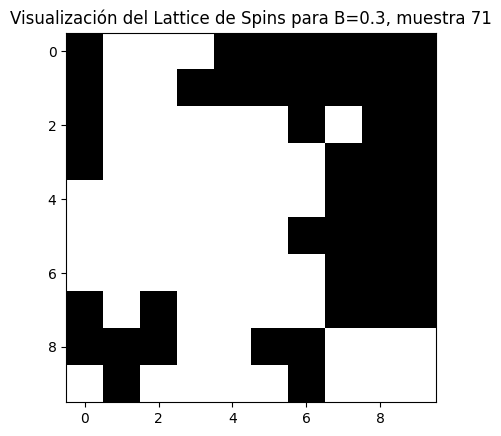

In [ ]:
def plot_graph(beta,lattice,sample_selected):
    plt.imshow(lattice[sample_selected], cmap='gray', interpolation='nearest')
    plt.title(f'Visualización del Lattice de Spins para B={beta}, muestra {sample_selected}')
    plt.show()

beta_slider = widgets.SelectionSlider(
    options=betas,
    description='beta:',
    continuous_update=False,
    orientation='horizontal',
)

samples_slider = widgets.SelectionSlider(
    options=[i for i in range(0,samples_to_take)],
    description='Samples:',
    continuous_update=False,
    orientation='horizontal',
)

display(beta_slider)
display(samples_slider)

def on_value_change(change):
    beta_selected = beta_slider.value
    sample_selected = samples_slider.value
    clear_output(wait=True)
    display(beta_slider)
    display(samples_slider)
    plot_graph(beta_selected,samples_taken[str(beta_selected)],sample_selected)
    #print(samples_taken[str(beta_selected)])

samples_slider.observe(on_value_change, names='value')
beta_slider.observe(on_value_change, names='value')

La ejecución de la siguiente celda es opcional y permite generar videos de la evolución del latice para el beta indicado.


In [ ]:
create_video(samples_taken['0'], '0')
create_video(samples_taken['0.1'], '0.1')
create_video(samples_taken['0.4'], '0.4')
create_video(samples_taken['0.8'], '0.8')
create_video(samples_taken['1'], '1')

>> 101
>> 101
>> 101
>> 101
>> 101


##Punto b)

El objetivo de este punto es utlizar el algoritmo deprop-wilson para generar muestras exactas de la distribución de Bolztman. Para esta aplicación se utlizara la técnica del sandwiching para reducir considerablemente el tiempo de ejecución del algoritmo.

Para el sandwiching se evaluarán las configuraciones extremas del lattice, es decir, cuando todas las particulas tienen un spin -1 y cuando todas las particulas tienen un spin +1. Cuando estas dos configuraciones coalescen, se garantiza que cualquier configuración intermedia también lo habrá hecho, lo que asegura que se ha alcanzado la distribución estacionaria del sistema. A continuación se describe el funcionamiento del algoritmo.


1.   Se crean dos lattices, uno tendra todas las particulas con spin -1 y el otro tendrá todas sus particulas con spin +1.
2.   Se elije un tiempo N que corresponde a los pasos desde el pasado (CFTP) que ejecutará el gibbs sampler hasta el tiempo t=0.
3.   Se evaluará si ambos lattices coalecen, es decir si convergieron a la misma configuración.
4.   Si lo lattices no colaence, se incrementa de forma exponencial el tiempo N hasta que haya coalecencia.
5. Se reporta el tiempo de coalecencia

El código de la siguiente celda recorrerá una lista que contiene los valores de beta que se busca evaluar, por cada beta se generarán 100 muestras usando Prop-Wilson,una vez haya coalescencia, se guarda la muestra resultante y su respectivo tiempo del Gibbs-Sampler.



In [ ]:
samples_taken_punto_b={}
samples_to_take = 100 #Cantidad de muestras para cada algoritmo
betas = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]
GS_time=0
for beta in betas:
  print(f"***Obtención de 100 muestras para k={side_size} y beta={beta}")
  samples_taken_punto_b[str(beta)]={"samples":[],"GB_time":[], "coalescence_time_sg":[]}
  for j in range(samples_to_take):
    is_equal=False
    N=1
    t=time.time()
    while is_equal==False:
      g_positve = ColourGraph(side_size=side_size,beta=beta,specif_spin=1)
      g_negative = ColourGraph(side_size=side_size,beta=beta,specif_spin=-1)
      GS_time=0
      for i in range(N):
        a=g_negative.sys_gibbs_step()
        g_positve.sys_gibbs_step(U_list=a)
        is_equal=np.array_equal(g_positve.lattice_as_matrix(),g_negative.lattice_as_matrix())
        if is_equal:
          GS_time=i
          break
      print(">>> No hay coalescencia para N: ",N, f" beta: {beta}, muestra: {j}")
      if not is_equal:
        N=2*N
    samples_taken_punto_b[str(beta)]["samples"].append(g_positve)
    samples_taken_punto_b[str(beta)]["GB_time"].append(GS_time)
    samples_taken_punto_b[str(beta)]["coalescence_time_sg"].append(time.time()-t)
    print(f">(beta {beta}) Colascencia, N: ",N,", GS_time: ",GS_time, "Tiempo de convergencia en (sg): ",samples_taken_punto_b[str(beta)]["coalescence_time_sg"][-1])

Se truncaron las últimas líneas 5000 del resultado de transmisión.
>>> No hay coalescencia para N:  2  beta: 0.3, muestra: 61
>>> No hay coalescencia para N:  4  beta: 0.3, muestra: 61
>>> No hay coalescencia para N:  8  beta: 0.3, muestra: 61
>>> No hay coalescencia para N:  16  beta: 0.3, muestra: 61
>>> No hay coalescencia para N:  32  beta: 0.3, muestra: 61
>(beta 0.3) Colascencia, N:  32 , GS_time:  10 Tiempo de convergencia en (sg):  0.05059194564819336
>>> No hay coalescencia para N:  1  beta: 0.3, muestra: 62
>>> No hay coalescencia para N:  2  beta: 0.3, muestra: 62
>>> No hay coalescencia para N:  4  beta: 0.3, muestra: 62
>>> No hay coalescencia para N:  8  beta: 0.3, muestra: 62
>>> No hay coalescencia para N:  16  beta: 0.3, muestra: 62
>(beta 0.3) Colascencia, N:  16 , GS_time:  8 Tiempo de convergencia en (sg):  0.02971053123474121
>>> No hay coalescencia para N:  1  beta: 0.3, muestra: 63
>>> No hay coalescencia para N:  2  beta: 0.3, muestra: 63
>>> No hay coalescencia

##Punto c)

{'0': 0.0, '0.1': 0.1, '0.2': 0.2, '0.3': 0.16, '0.4': 0.02, '0.5': 0.12, '0.6': 0.98, '0.7': 0.92}
{'0': 0.04, '0.1': 0.02, '0.2': 0.18, '0.3': 0.28, '0.4': 0.32, '0.5': 0.9, '0.6': 0.78, '0.7': 0.96, '0.8': 0.98, '0.9': 0.98, '1': 1.0}


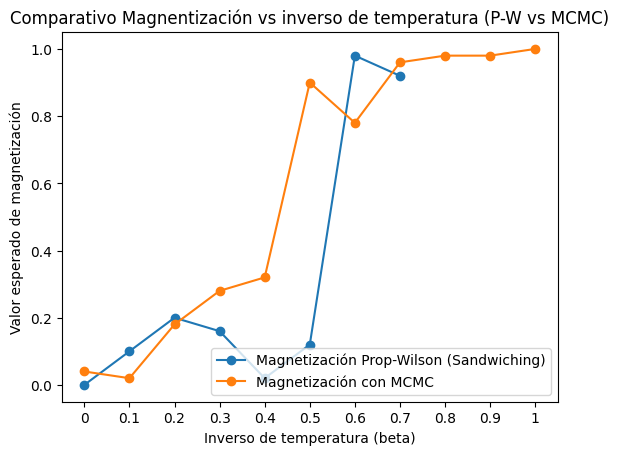

In [ ]:
E_Mu_propp_wilson={} #Experanza de la magneitzación para algortimo Propp-Wilson
E_Mu_only_gibbs_sampler={} #Experanza de la magnetización para algortimo sol utilizando Gibbs-Sampler y tiempo definido

for b in samples_taken_punto_b:
  for lattice in samples_taken_punto_b[b]["samples"]:
    E_Mu_propp_wilson[b]=abs(lattice.magnetization())

for b1 in samples_taken:
  for l in samples_taken[b1]:
    E_Mu_only_gibbs_sampler[b1]=abs(np.mean(l))

plt.plot(E_Mu_propp_wilson.keys(), E_Mu_propp_wilson.values(), marker='o', label="Magnetización Prop-Wilson (Sandwiching)")
plt.plot(E_Mu_only_gibbs_sampler.keys(), E_Mu_only_gibbs_sampler.values(), marker='o', label="Magnetización con MCMC")

# Etiquetas y título
plt.xlabel('Inverso de temperatura (beta)')
plt.ylabel('Valor esperado de magnetización')
plt.title('Comparativo Magnentización vs inverso de temperatura (P-W vs MCMC)')
plt.legend()

# Mostrar el gráfico
print(E_Mu_propp_wilson)
print(E_Mu_only_gibbs_sampler)
plt.show()

###Otras gráficas relacionas a tiempos de coalescencia del Prop-Wilson

Las siguiente gráficas son relacionadas al experimento usando el algoritmo de prop-wilson y la técnica de sandwiching

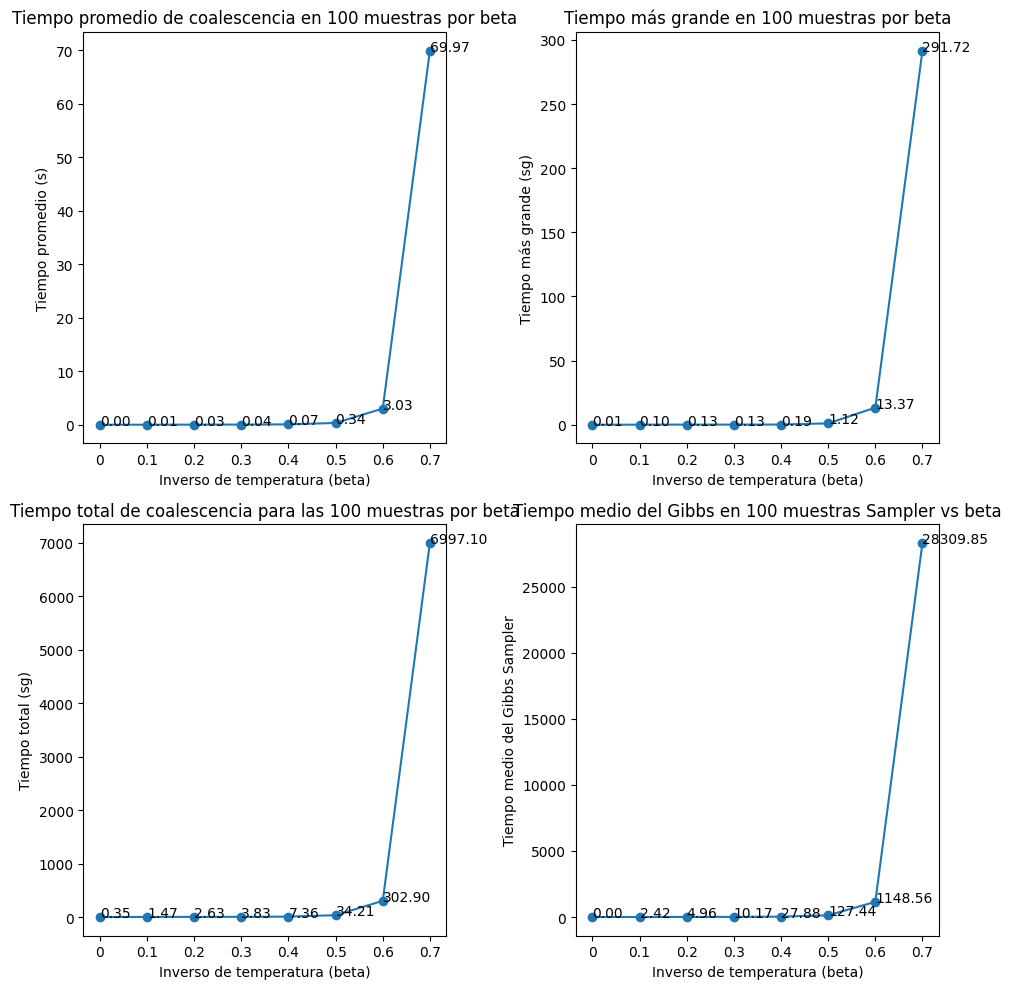

In [ ]:
time_sg_by_beta = [ np.mean(beta["coalescence_time_sg"]) for beta in samples_taken_punto_b.values()]
max_sg_by_beta = [ np.max(beta["coalescence_time_sg"]) for beta in samples_taken_punto_b.values()]
total_sg_by_beta = [ np.sum(beta["coalescence_time_sg"]) for beta in samples_taken_punto_b.values()]
mean_gibb_sampler_steps = [ np.mean(beta["GB_time"]) for beta in samples_taken_punto_b.values()]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(samples_taken_punto_b.keys(), time_sg_by_beta, marker='o', label="Tiempo promedio de coalescencia")
axs[0, 0].set_xlabel('Inverso de temperatura (beta)')
axs[0, 0].set_ylabel('Tiempo promedio (s)')
axs[0, 0].set_title(f'Tiempo promedio de coalescencia en {samples_to_take} muestras por beta')
for i, txt in enumerate(time_sg_by_beta):
    axs[0, 0].annotate(f'{txt:.2f}', (list(samples_taken_punto_b.keys())[i], time_sg_by_beta[i]))

axs[0, 1].plot(samples_taken_punto_b.keys(), max_sg_by_beta, marker='o', label="Tiempo más grande en alguna muestra")
axs[0, 1].set_xlabel('Inverso de temperatura (beta)')
axs[0, 1].set_ylabel('Tiempo más grande (sg)')
axs[0, 1].set_title(f'Tiempo más grande en {samples_to_take} muestras por beta')
for i, txt in enumerate(max_sg_by_beta):
    axs[0, 1].annotate(f'{txt:.2f}', (list(samples_taken_punto_b.keys())[i], max_sg_by_beta[i]))

axs[1, 0].plot(samples_taken_punto_b.keys(), total_sg_by_beta, marker='o', label=f"Tiempo total para la generacion de las {samples_to_take} muestras")
axs[1, 0].set_xlabel('Inverso de temperatura (beta)')
axs[1, 0].set_ylabel('Tiempo total (sg)')
axs[1, 0].set_title(f'Tiempo total de coalescencia para las {samples_to_take} muestras por beta')
for i, txt in enumerate(total_sg_by_beta):
    axs[1, 0].annotate(f'{txt:.2f}', (list(samples_taken_punto_b.keys())[i], total_sg_by_beta[i]))

axs[1, 1].plot(samples_taken_punto_b.keys(), mean_gibb_sampler_steps, marker='o')
axs[1, 1].set_xlabel('Inverso de temperatura (beta)')
axs[1, 1].set_ylabel('Tiempo medio del Gibbs Sampler')
axs[1, 1].set_title(f'Tiempo medio del Gibbs en {samples_to_take} muestras Sampler vs beta')
for i, txt in enumerate(mean_gibb_sampler_steps):
    axs[1, 1].annotate(f'{txt:.2f}', (list(samples_taken_punto_b.keys())[i], mean_gibb_sampler_steps[i]))


plt.tight_layout()
plt.show()



In [ ]:
#list(samples_taken_punto_b.keys()
dataframe = pd.DataFrame({
    "Beta":list(samples_taken_punto_b.keys()),
    f"Tiempo(sg) promero de coalescencia por {samples_to_take} muestras":time_sg_by_beta,
    f"Máx. tiempo(sg) por {samples_to_take} muestras":max_sg_by_beta,
    f"Tiempo(sg) de generación de {samples_to_take} muestras":total_sg_by_beta,
    f"Media de pasos del G.S por {samples_to_take} muestras":mean_gibb_sampler_steps

})

dataframe

,Beta,Tiempo(sg) promero de coalescencia por 100 muestras,Máx. tiempo(sg) por 100 muestras,Tiempo(sg) de generación de 100 muestras,Media de pasos del G.S por 100 muestras
0,0,0.003513,0.014870,0.351255,0.00
1,0.1,0.014675,0.095562,1.467454,2.42
2,0.2,0.026309,0.134487,2.630861,4.96
3,0.3,0.038264,0.134663,3.826417,10.17
4,0.4,0.073590,0.185893,7.358963,27.88
5,0.5,0.342097,1.120745,34.209724,127.44
6,0.6,3.029022,13.373202,302.902189,1148.56
7,0.7,69.970960,291.724850,6997.095964,28309.85


#Problema 2: Optimización del Camino de la Hormiga
Una hormiga ha sido desalojada de su colonia ubicada en la parcela
$[0,1]\times[0,1]$ y decide visitar todas las otras 75 colonias de su parcela sin repetir ninguna. Para ayudar a la hormiga a encontrar el camino óptimo, se implementó un algoritmo de Simulated Annealing.

Lo siguiente extrae lo datos de archivo que fue compartido en clase (Problema de la hormiga desalojada) , para que lo siguiente funcione, el archivo debe estar en la carpeta raíz del drive del usuario.

**Notas importantes**



1.   El siguiente código va a solicitar permisos de acceso a la cuenta de la universidad para buscar el archivo dentro del drive.
2.   Si lo anterior no funciona, descargue el siguiente csv ([CLIC AQUÍ](https://drive.google.com/file/d/1Rdq57K9Xq6QLPmlxnKq15uscQf7tvpqN/view?usp=drive_link)) que contiene los datos compartidos y subalo al entorno de google colab (sin añadirlo a ninguna carpeta) con el nombre *datos.csv*. **y cambie el valor de variable *use_from_csv* a True**, la variable mencionada está en la celda de abajo.



## Rutinas para carga de archivo y metodos para el algoritmo

In [ ]:
use_from_csv=True #TRUE para cargar datos desde .csv, FALSE para leer el archivo desde drive

U = [random() for _ in range(10 ** 5)]

if use_from_csv:
  df=pd.read_csv("datos.csv",header=0)
  puntos = list(df.to_records(index=False))
else:
  from google.colab import auth
  auth.authenticate_user()

  import gspread
  from google.auth import default
  creds, _ = default()

  gc = gspread.authorize(creds)

  worksheet = gc.open('Problema de la hormiga desalojada').sheet1

  # get_all_values gives a list of rows.
  rows = worksheet.get_all_values()

  puntos = [(float(rows[l][0].replace(',', '.')), float(rows[l][1].replace(',', '.'))) for l in range(1, len(rows) - 6)]

#puntos

In [ ]:
def euclideanDistance(p1 : tuple[float, float], p2 : tuple[float, float]) -> float:
  """
  Dados dos puntos p1 y p2.

  Retorna la distancia euclideana entre ellos.
  """

  return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5

def lengthOfPath(path : list[int], points : list[tuple[int, int]]) -> float:
  """
  Dado un camino path,
  y una lista de puntos points.

  Retorna la longitud del camino.
  """
  length = 0
  for i in range(len(path) - 1):
    length += euclideanDistance(points[path[i]], points[path[i + 1]])

  return length

def createValidPath(points : list[tuple[int, int]]) -> list[int]:
  """
  Dada una lista de puntos points,

  Retorna un camino que pasa por
  todos los puntos empezando por
  points[0] sin repetir ninguno.
  """

  basicPath = [i for i in range(1, len(points))]
  path = [0] + sample(basicPath, len(basicPath))

  return path

def gibbsStepForPaths(path : list[int], points : list[tuple[int, int]], T : float, U : list[float]) -> list[int]:
  """
  Dados un camino path,
  una lista de puntos points,
  una temperatura T,
  y una lista de numeros aleatorios entre 0 y 1 U.

  Realiza un Gibbs Step para hallar un nuevo
  camino con las probabilidades asignadas.

  Importante: El Gibbs Step nunca movera el primer punto del camino.
  """

  currentPath = path.copy()
  for flip in range(1, min(len(path) - 1, len(U) - 1)):
    newPath = currentPath.copy()

    temp = newPath[flip + 1]
    newPath[flip + 1] = newPath[flip]
    newPath[flip] = temp

    difference = lengthOfPath(newPath, points) - lengthOfPath(path, points)
    probabilityOfChange = math.exp(- difference / T) / (1 + math.exp(- difference / T))

    if U[flip] < probabilityOfChange:
      currentPath = newPath

  return currentPath


def plot_path(path, points, title="Camino"):
    """
    Dibuja el camino dado una lista de puntos y el camino.
    """
    path_points = [points[i] for i in path]

    # Extraer coordenadas
    x_coords, y_coords = zip(*path_points)

    plt.figure(figsize=(10, 8))

    # Dibujar el camino con una línea
    plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b')

    # Dibujar todos los puntos originales
    plt.scatter(*zip(*points), color='gray', zorder=5)  # Puntos originales en gris

    # Resaltar el punto inicial
    plt.scatter(x_coords[0], y_coords[0], color='g', zorder=6, s=100, label='Inicio (Punto 0)')

    # Resaltar el punto final
    plt.scatter(x_coords[-1], y_coords[-1], color='r', zorder=7, s=100, label='Fin')

    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.legend()
    plt.show()

##Punto a)

Parte a) Optimización del Camino Sin Retorno
Se utilizó el algoritmo Simulated Annealing para determinar el camino más corto que recorre todas las colonias, sin volver a la colonia original. El esquema de enfriamiento empleado consistió en disminuir la temperatura $T$ en potencias de
$1/ 1.3$, realizando una serie de pasos de Gibbs en cada iteración para optimizar el camino.

\\
Esquema de enfriamiento:


* Temperatura inicial: $T_0 = 1$

* Cada iteración reduce la temperatura según la fórmula: $T[i]={1.3}^{-i}$

* Número de iteraciones por temperatura: $N[i]= 2^{i}$

Resultados:

Distancia mínima obtenida: Después de realizar múltiples pasos de Gibbs a lo largo de las iteraciones, se obtuvo un camino con la menor longitud posible, considerando la configuración de temperatura y número de iteraciones.

Mapa generado: El camino final obtenido se graficó, mostrando el recorrido de la hormiga por todas las colonias sin regresar al punto de origen


----- Temperatura = 1.0 -----
----- Iteraciones = 1 -----
----- Longitud del camino actual: 41.02467007725989 -----


----- Temperatura = 0.7692307692307692 -----
----- Iteraciones = 2 -----
----- Longitud del camino actual: 40.43537559800686 -----


----- Temperatura = 0.5917159763313609 -----
----- Iteraciones = 4 -----
----- Longitud del camino actual: 39.93197247379925 -----


----- Temperatura = 0.45516613563950836 -----
----- Iteraciones = 8 -----
----- Longitud del camino actual: 37.79660759863861 -----


----- Temperatura = 0.35012779664577565 -----
----- Iteraciones = 16 -----
----- Longitud del camino actual: 37.94117727364757 -----


----- Temperatura = 0.2693290743429043 -----
----- Iteraciones = 32 -----
----- Longitud del camino actual: 33.909036736006726 -----


----- Temperatura = 0.20717621103300332 -----
----- Iteraciones = 64 -----
----- Longitud del camino actual: 31.58046476052223 -----


----- Temperatura = 0.15936631617923333 -----
----- Iteraciones = 128 -----


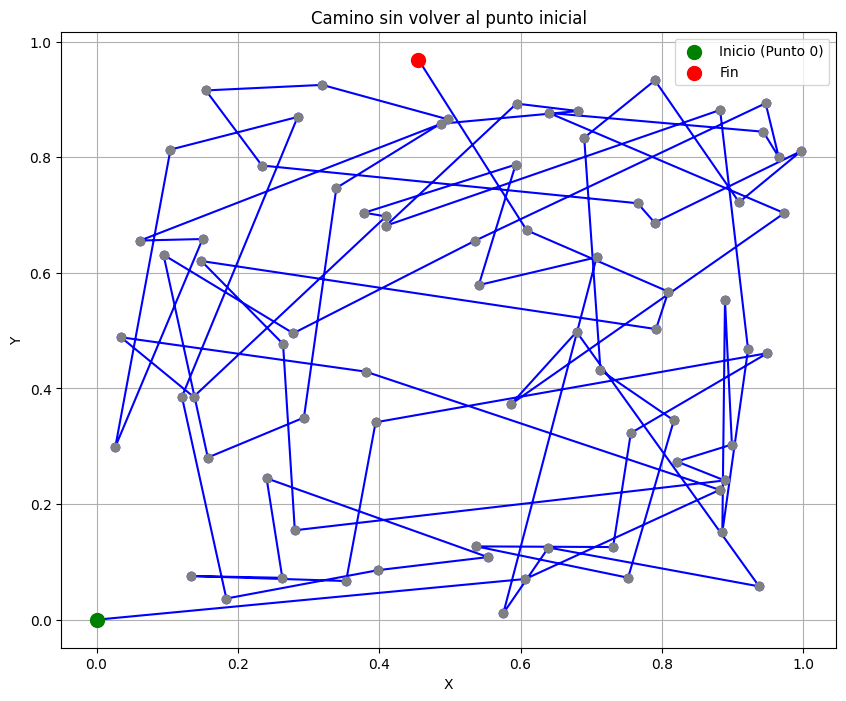

In [ ]:
samples = 10
T = [1.3 ** (-i) for i in range(samples)]
N = [2 ** i for i in range(samples)]

currentPathI = createValidPath(puntos)
suma = 0

for s in range(samples):
  print(f"\n----- Temperatura = {T[s]} -----")
  print(f"----- Iteraciones = {N[s]} -----")
  #print(f"----- Camino actual: {currentPathI} -----")
  print(f"----- Longitud del camino actual: {lengthOfPath(currentPathI, puntos)} -----\n")
  newPath = currentPathI.copy()
  for i in range(N[s]):
    newPath = gibbsStepForPaths(newPath, puntos, T[s], U[(i + suma) * len(puntos) : (i + suma + 1) * len(puntos)])
  currentPathI = newPath
  suma += N[s]

print(f"Camino final: {currentPathI}")
print(f"Longitud del camino final: {lengthOfPath(currentPathI, puntos)}")



# Graficar el camino sin regresar al punto inicial
plot_path(currentPathI, puntos, title="Camino sin volver al punto inicial")

##Punto b) Repita lo que se hizo en 2. a) pero donde la hormiga vuelve al punto inicial.

En esta variación, se sabe que la hormiga regresará a su colonia original después de haber recorrido todas las otras colonias. Para ello, se adaptó el algoritmo de Simulated Annealing para incluir este requerimiento.

Esquema de enfriamiento:

* Temperatura inicial: $T_0 = 1$

* Cada iteración reduce la temperatura según la fórmula: $T[i]={1.5}^{-i}$

* Número de iteraciones por temperatura: $N[i]= 2^{i}$

Resultados:

Distancia mínima obtenida: Se optimizó el camino teniendo en cuenta el retorno al punto inicial, obteniendo la menor longitud posible bajo el mismo esquema de temperatura y pasos de Gibbs.
Mapa generado: Se graficó el camino que la hormiga tomaría, destacando el regreso a la colonia original.

In [ ]:
def gibbsStepForCircPaths(path : list[int], points : list[tuple[int, int]], T : float, U : list[float]) -> list[int]:
  """
  Dados un camino path,
  una lista de puntos points,
  una temperatura T,
  y una lista de numeros aleatorios entre 0 y 1 U.

  Realiza un Gibbs Step para hallar un nuevo
  camino con las probabilidades asignadas.

  Importante: El Gibbs Step nunca movera
  el primer ni el ultimo punto del camino.
  """

  currentPath = path.copy()
  for flip in range(1, min(len(path) - 1, len(U) - 1) - 1):
    newPath = currentPath.copy()

    temp = newPath[flip + 1]
    newPath[flip + 1] = newPath[flip]
    newPath[flip] = temp

    difference = lengthOfPath(newPath, points) - lengthOfPath(path, points)
    probabilityOfChange = math.exp(- difference / T) / (1 + math.exp(- difference / T))

    if U[flip] < probabilityOfChange:
      currentPath = newPath

  return currentPath


----- Temperatura = 1.0 -----
----- Iteraciones = 1 -----
----- Longitud del camino actual: 38.680432528609344 -----


----- Temperatura = 0.6666666666666666 -----
----- Iteraciones = 2 -----
----- Longitud del camino actual: 39.90828110072038 -----


----- Temperatura = 0.4444444444444444 -----
----- Iteraciones = 4 -----
----- Longitud del camino actual: 38.661704413976636 -----


----- Temperatura = 0.2962962962962963 -----
----- Iteraciones = 8 -----
----- Longitud del camino actual: 35.61337620586872 -----


----- Temperatura = 0.19753086419753085 -----
----- Iteraciones = 16 -----
----- Longitud del camino actual: 31.802936223087148 -----


----- Temperatura = 0.13168724279835392 -----
----- Iteraciones = 32 -----
----- Longitud del camino actual: 28.533956000500684 -----


----- Temperatura = 0.0877914951989026 -----
----- Iteraciones = 64 -----
----- Longitud del camino actual: 26.80546115438941 -----


----- Temperatura = 0.05852766346593507 -----
----- Iteraciones = 128 ----

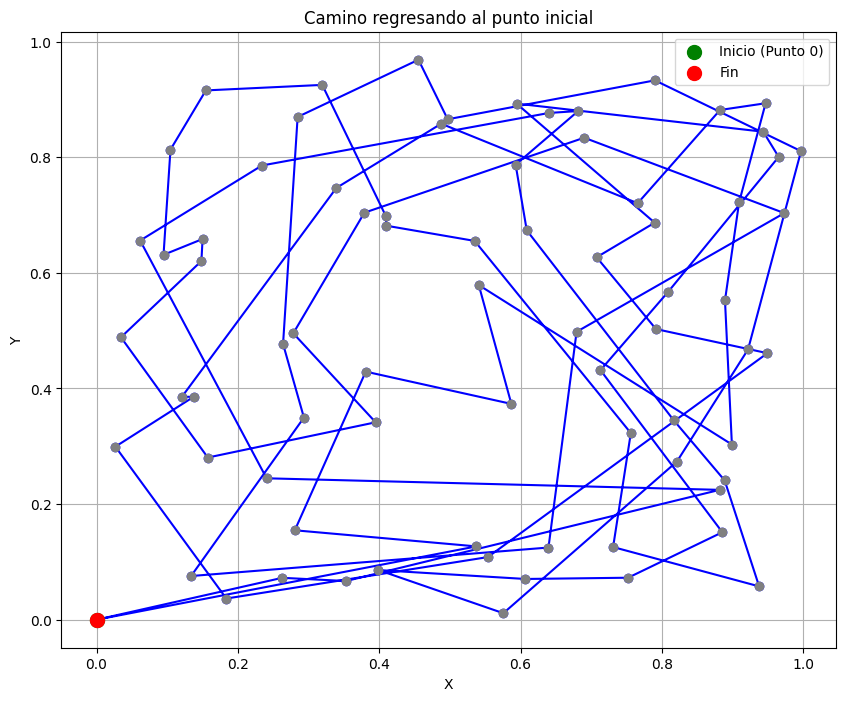

In [ ]:
samples = 10
T = [1.5 ** (-i) for i in range(samples)]
N = [2 ** i for i in range(samples)]

currentPath = createValidPath(puntos) + [0] # Un camino que empieza y termina en el primer punto (el punto 0).
suma = 0

for s in range(samples):
  print(f"\n----- Temperatura = {T[s]} -----")
  print(f"----- Iteraciones = {N[s]} -----")
  #print(f"----- Camino actual: {currentPath} -----")
  print(f"----- Longitud del camino actual: {lengthOfPath(currentPath, puntos)} -----\n")
  newPath = currentPath.copy()
  for i in range(N[s]):
    newPath = gibbsStepForCircPaths(newPath, puntos, T[s], U[(i + suma) * len(puntos) : (i + suma + 1) * len(puntos)])
  currentPath = newPath
  suma += N[s]

print(f"Camino final: {currentPath}")
print(f"Longitud del camino final: {lengthOfPath(currentPath, puntos)}")
# Graficar el camino regresando al punto inicial
plot_path(currentPath + [0], puntos, title="Camino regresando al punto inicial")

#Conclusiones

  1. Debido al la gran cantidad de pruebas que se hiceron con diferentes valores de K (k x k) y a los extensos tiempos de coalescencia con el algoritmo de Prop-Wilson. Se decidio tomar resultados con un valore de K=10 para al menos tener resultados con 0<= β <= 0.7 por las razones que se explican a continuación.
  
  Respecto al algoritmo de Prop-Wilson con la técnica del Sandwiching, se notó una muy rápida coalescencia para $β$ pequeños (temperaturas altas), pero para betas mayores a 0.7 la (por o menos para nuestra implementación) es incierto porque no nos fue posible conseguir 100 muestras para $β \geq 0.8$. Según el comportamiento observado, se noto que en despues de $ \beta = 0.7$ todas las simulaciones tardaban demasiado en completar, como si fuese un valor crítico.

  Una posible razón para lo anterior, es que como para betas altos las configuraciones se vuelven más ordenadas, dando una especie de "rigidez" al cambio, o haciendo al "material" en términos de magnetización, pues esto generar que los latices en que se usan en la técnica de sandwiching cambien con mas dificultad, generando que los tiempos de coalescencia se incrementen demasiado, según busquedas en internet, estos tiempo de coalescencia tiene un comportamiento exponencial, pero no podemos afirmarlos porque no lo pudimos comprobar. Algo que puede dar soporte a la idea anterior es ejecutar la celda para el literal a) donde se usa el gibbs sampler con una cota de tiempo, y ver usan el slider que permite visulizar las muestras por cada $\beta$ , y visualizar que para betas despues de 0.5 el lattice tiende a ordenarse rapidamente, y a cambiar poco, que este comportamiento es a lo que se apela cuando se afirma que una vez organizados los latices que se usan en el algoritmo de prop-wilson, cambian poco y el tiempo de coalescencia va a ser alto.

  2. El uso del algoritmo de Simulated Annealing fue adecuado para encontrar una solución cercana al óptimo en el problema de la hormiga. Aunque no garantiza encontrar el camino perfecto, el esquema de enfriamiento empleado permitió reducir significativamente la distancia recorrida por la hormiga.
  El esquema de enfriamiento juega un papel clave en la calidad de la solución. Al disminuir la temperatura gradualmente y aumentar las iteraciones a medida que avanza el proceso, el algoritmo tuvo mayor oportunidad de explorar caminos mejores sin quedar atrapado en mínimos locales.

  Diferencia entre los dos escenarios literal a) y b): La inclusión del retorno al punto original en la segunda parte del problema añade complejidad a la búsqueda del camino más corto, ya que obliga a la hormiga a volver al punto inicial. Esto se refleja en una distancia final ligeramente mayor que en el escenario donde no es necesario regresar.

  La representación gráfica del camino recorrido permitió verificar visualmente los resultados y comprobar que efectivamente la hormiga visitaba todas las colonias sin repetir ninguna, cumpliendo con las restricciones planteadas.

  Los resultados podrían mejorarse ajustando los parámetros del Simulated Annealing, como la tasa de enfriamiento o el número de iteraciones en cada etapa. Además, otros algoritmos de optimización podrían ser explorados en futuras implementaciones para comparar su desempeño en este tipo de problemas.
  
  En particular, se destaca la elección de $1.3$ como base para la tasa de enfriamiento. Si se hubiese escogido un valor mayor, como $2$, los caminos obtenidos habrían sido de mayor longitud, ya que un esquema de enfriamiento más rápido aumenta la probabilidad de quedar atrapado en un mínimo local. Esto resalta la importancia de encontrar un balance adecuado en la tasa de enfriamiento para optimizar el resultado sin sacrificar la calidad de la solución

